In [109]:
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.lite as tflite
%matplotlib inline





In [53]:
#Assign paths to images

In [54]:
path = './data/'
negative_imgs = path + "Negative/*.jpg"
positive_imgs = path + "Positive/*.jpg"

In [55]:
#all images

In [56]:
path_imgs = list(glob.glob(path + "**/*.jpg"))

Text(0.5, 1.0, 'Positive and Negative')

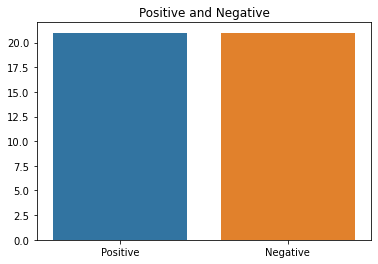

In [57]:
sns.barplot(x=['Positive', 'Negative'], y=[len(positive_imgs), len(negative_imgs)],)
plt.title('Positive and Negative')

In [58]:
dir_positive = Path('./data/Positive')   #directory for positive images

dir_negative = Path('./data/Negative')  # director for negative images

In [59]:
Random_State=28

In [60]:
#function for creating dataframes

def df_create(dir, label):
    filepaths= pd.Series(list(dir.glob(r"*.jpg")), name='File').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    
    return df

In [61]:
df_positive = df_create(dir_positive, label= 'positive')
df_negative = df_create(dir_negative, label= 'negative')

In [62]:
df = pd.concat([df_positive, df_negative], axis=0).sample(frac=1.0, random_state = Random_State).reset_index(drop=True)

In [63]:
df.head()

,File,Label
0,data/Negative/16522.jpg,negative
1,data/Positive/13279_1.jpg,positive
2,data/Positive/10841_1.jpg,positive
3,data/Positive/16009_1.jpg,positive
4,data/Negative/10957.jpg,negative


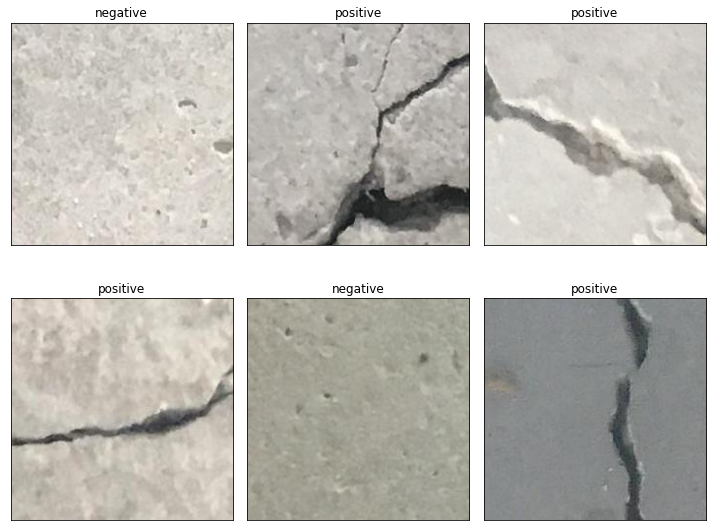

In [64]:
#plot images

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,8), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.File[i]))
    ax.set_title(df.Label[i])
plt.tight_layout()
plt.show()

In [65]:
#Divide the data into train and test datasets

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=Random_State)

In [66]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255) 

In [67]:
IMAGE_SHAPE = 150
BATCH_SIZE = 20

In [68]:
train_ds = train_datagen.flow_from_dataframe(
        train_df,
        x_col= 'File',
        y_col= 'Label',
        batch_size= BATCH_SIZE,
        target_size= (IMAGE_SHAPE, IMAGE_SHAPE),
        seed = Random_State,
        class_mode='binary',
        shuffle= True )
test_ds =  val_datagen.flow_from_dataframe(
        test_df,
        x_col= 'File',
        y_col= 'Label',
        batch_size= BATCH_SIZE,
        target_size= (IMAGE_SHAPE, IMAGE_SHAPE),
        seed = Random_State,
        class_mode= 'binary',
        shuffle= True )


Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [18]:
#Create first CNN model 

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
    input_shape= (IMAGE_SHAPE, IMAGE_SHAPE, 3),
    filters= 32,
    kernel_size= 3,
    activation= 'relu'  
    ),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(
    filters=32,
    kernel_size= 3,
    activation= 'relu'
    ),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')]
    )  

2021-12-08 04:56:41.595235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 04:56:41.595275: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 04:56:41.595294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VUA8337): /proc/driver/nvidia/version does not exist
2021-12-08 04:56:41.595483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
lr=0.002
momentum=0.8
optimizer= keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

model.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
             metrics= [tf.keras.metrics.BinaryAccuracy()], 
             )

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [22]:
history=model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
     validation_data=test_ds,
    validation_steps=50
)

2021-12-06 07:28:58.214809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
100/100 [==============================] - 24s 240ms/step - loss: 0.2495 - binary_accuracy: 0.4970 - val_loss: 0.2495 - val_binary_accuracy: 0.4890
Epoch 2/10
100/100 [==============================] - 23s 230ms/step - loss: 0.2492 - binary_accuracy: 0.4965 - val_loss: 0.2490 - val_binary_accuracy: 0.4900
Epoch 3/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2484 - binary_accuracy: 0.5100 - val_loss: 0.2471 - val_binary_accuracy: 0.5210
Epoch 4/10
100/100 [==============================] - 24s 243ms/step - loss: 0.2485 - binary_accuracy: 0.5000 - val_loss: 0.2478 - val_binary_accuracy: 0.5040
Epoch 5/10
100/100 [==============================] - 23s 228ms/step - loss: 0.2484 - binary_accuracy: 0.4890 - val_loss: 0.2482 - val_binary_accuracy: 0.5230
Epoch 6/10
100/100 [==============================] - 24s 236ms/step - loss: 0.2481 - binary_accuracy: 0.5525 - val_loss: 0.2476 - val_binary_accuracy: 0.4950
Epoch 7/10
100/100 [==========================

In [23]:
history=model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
1600/1600 [==============================] - 313s 196ms/step - loss: 0.2425 - binary_accuracy: 0.5786 - val_loss: 0.2381 - val_binary_accuracy: 0.7124
Epoch 2/10
1600/1600 [==============================] - 281s 176ms/step - loss: 0.2339 - binary_accuracy: 0.6522 - val_loss: 0.2267 - val_binary_accuracy: 0.7096
Epoch 3/10
1600/1600 [==============================] - 287s 179ms/step - loss: 0.2234 - binary_accuracy: 0.6715 - val_loss: 0.2136 - val_binary_accuracy: 0.7015
Epoch 4/10
1600/1600 [==============================] - 299s 187ms/step - loss: 0.2122 - binary_accuracy: 0.6974 - val_loss: 0.2015 - val_binary_accuracy: 0.7154
Epoch 5/10
1600/1600 [==============================] - 297s 186ms/step - loss: 0.1978 - binary_accuracy: 0.7396 - val_loss: 0.1884 - val_binary_accuracy: 0.7374
Epoch 6/10
1600/1600 [==============================] - 297s 186ms/step - loss: 0.1717 - binary_accuracy: 0.7977 - val_loss: 0.1504 - val_binary_accuracy: 0.8494
Epoch 7/10
1600/1600 [======

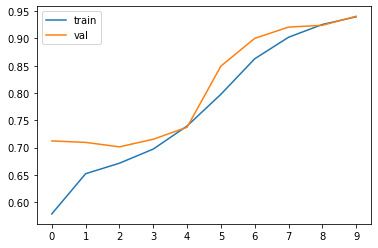

In [25]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [22]:
# model 3: Xception

In [69]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [70]:
base_model= Xception(
            weights = 'imagenet',
            input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
            include_top = False,
            )
base_model.trainable= False
inputs= keras.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
base= base_model(inputs, training=False)
pooling= keras.layers.GlobalAveragePooling2D()
vector = pooling(base)
outputs = keras.layers.Dense(1)(vector)
model_X=keras.Model(inputs, outputs)

In [71]:
model_X.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [72]:
model_X.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
             metrics= [tf.keras.metrics.BinaryAccuracy()], 
             )

In [43]:
history_X=model_X.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
1600/1600 [==============================] - 553s 344ms/step - loss: 0.0255 - binary_accuracy: 0.9893 - val_loss: 0.0192 - val_binary_accuracy: 0.9942
Epoch 2/10
1600/1600 [==============================] - 539s 337ms/step - loss: 0.0164 - binary_accuracy: 0.9952 - val_loss: 0.0163 - val_binary_accuracy: 0.9952
Epoch 3/10
1600/1600 [==============================] - 523s 327ms/step - loss: 0.0144 - binary_accuracy: 0.9957 - val_loss: 0.0149 - val_binary_accuracy: 0.9962
Epoch 4/10
1600/1600 [==============================] - 520s 325ms/step - loss: 0.0133 - binary_accuracy: 0.9962 - val_loss: 0.0141 - val_binary_accuracy: 0.9967
Epoch 5/10
1600/1600 [==============================] - 985s 616ms/step - loss: 0.0126 - binary_accuracy: 0.9966 - val_loss: 0.0136 - val_binary_accuracy: 0.9965
Epoch 6/10
1600/1600 [==============================] - 542s 339ms/step - loss: 0.0121 - binary_accuracy: 0.9967 - val_loss: 0.0130 - val_binary_accuracy: 0.9965
Epoch 7/10
1600/1600 [======

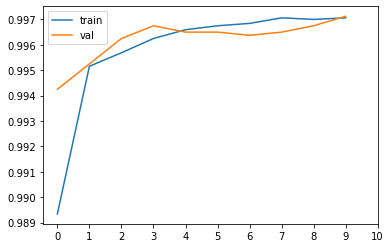

In [45]:
plt.plot(history_X.history['binary_accuracy'], label='train')
plt.plot(history_X.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(11))
plt.legend()

In [25]:
# model 4: VGG19

In [26]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions

In [27]:
base_model= VGG19(
            weights = 'imagenet',
            input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
            include_top = False,
            )
base_model.trainable= False
inputs= keras.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
base= base_model(inputs, training=False)
pooling= keras.layers.GlobalAveragePooling2D()
vector = pooling(base)
outputs = keras.layers.Dense(1)(vector)
model_vgg19=keras.Model(inputs, outputs)

In [28]:
model_vgg19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [30]:
model_vgg19.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
             metrics= [tf.keras.metrics.BinaryAccuracy()], 
             )

In [31]:
history_vgg19=model_vgg19.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=test_ds,
)

2021-12-08 04:57:39.912895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
100/100 [==============================] - 412s 4s/step - loss: 0.1048 - binary_accuracy: 0.8760 - val_loss: 0.0572 - val_binary_accuracy: 0.9621
Epoch 2/10
100/100 [==============================] - 414s 4s/step - loss: 0.0470 - binary_accuracy: 0.9690 - val_loss: 0.0414 - val_binary_accuracy: 0.9858
Epoch 3/10
100/100 [==============================] - 460s 5s/step - loss: 0.0350 - binary_accuracy: 0.9855 - val_loss: 0.0344 - val_binary_accuracy: 0.9876
Epoch 4/10
100/100 [==============================] - 446s 4s/step - loss: 0.0339 - binary_accuracy: 0.9885 - val_loss: 0.0332 - val_binary_accuracy: 0.9801
Epoch 5/10
100/100 [==============================] - 446s 4s/step - loss: 0.0308 - binary_accuracy: 0.9870 - val_loss: 0.0309 - val_binary_accuracy: 0.9908
Epoch 6/10
100/100 [==============================] - 2193s 22s/step - loss: 0.0317 - binary_accuracy: 0.9860 - val_loss: 0.0285 - val_binary_accuracy: 0.9876
Epoch 7/10
100/100 [==============================] - 43

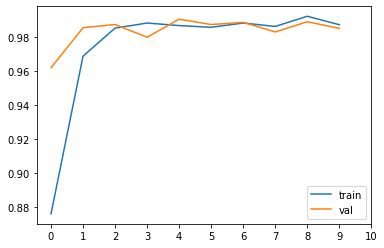

In [34]:
plt.plot(history_vgg19.history['binary_accuracy'], label='train')
plt.plot(history_vgg19.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(11))
plt.legend()

In [35]:
# model 5 ResNet50

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

In [37]:
base_model= ResNet50(
            weights = 'imagenet',
            input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
            include_top = False,
            )
base_model.trainable= False
inputs= keras.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
base= base_model(inputs, training=False)
pooling= keras.layers.GlobalAveragePooling2D()
vector = pooling(base)
outputs = keras.layers.Dense(1)(vector)
model_ResNet50=keras.Model(inputs, outputs)

94781440/94765736 [==============================] - 4s 0us/step


In [38]:
model_ResNet50.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [39]:
model_ResNet50.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
             metrics= [tf.keras.metrics.BinaryAccuracy()], 
             )

In [40]:
history_ResNet50=model_ResNet50.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
100/100 [==============================] - 153s 2s/step - loss: 0.2807 - binary_accuracy: 0.5870 - val_loss: 0.1842 - val_binary_accuracy: 0.6486
Epoch 2/10
100/100 [==============================] - 148s 1s/step - loss: 0.1370 - binary_accuracy: 0.8145 - val_loss: 0.1870 - val_binary_accuracy: 0.6695
Epoch 3/10
100/100 [==============================] - 151s 2s/step - loss: 0.1245 - binary_accuracy: 0.8375 - val_loss: 0.0968 - val_binary_accuracy: 0.9446
Epoch 4/10
100/100 [==============================] - 149s 1s/step - loss: 0.1231 - binary_accuracy: 0.8590 - val_loss: 0.0891 - val_binary_accuracy: 0.9069
Epoch 5/10
100/100 [==============================] - 149s 1s/step - loss: 0.1141 - binary_accuracy: 0.8685 - val_loss: 0.2262 - val_binary_accuracy: 0.6816
Epoch 6/10
100/100 [==============================] - 148s 1s/step - loss: 0.1061 - binary_accuracy: 0.8890 - val_loss: 0.0847 - val_binary_accuracy: 0.9130
Epoch 7/10
100/100 [==============================] - 148s

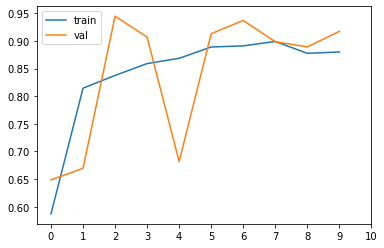

In [41]:
plt.plot(history_ResNet50.history['binary_accuracy'], label='train')
plt.plot(history_ResNet50.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(11))
plt.legend()

In [42]:
#model 6 VGG16

In [43]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

In [44]:
base_model= VGG16(
            weights = 'imagenet',
            input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
            include_top = False,
            )
base_model.trainable= False
inputs= keras.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
base= base_model(inputs, training=False)
pooling= keras.layers.GlobalAveragePooling2D()
vector = pooling(base)
outputs = keras.layers.Dense(1)(vector)
model_vgg16=keras.Model(inputs, outputs)

58900480/58889256 [==============================] - 3s 0us/step


In [45]:
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [46]:
model_vgg16.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
             metrics= [tf.keras.metrics.BinaryAccuracy()], 
             )

In [47]:
history_vgg16=model_vgg16.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
100/100 [==============================] - 326s 3s/step - loss: 0.1623 - binary_accuracy: 0.8850 - val_loss: 0.0534 - val_binary_accuracy: 0.9551
Epoch 2/10
100/100 [==============================] - 353s 4s/step - loss: 0.0455 - binary_accuracy: 0.9700 - val_loss: 0.0467 - val_binary_accuracy: 0.9703
Epoch 3/10
100/100 [==============================] - 362s 4s/step - loss: 0.0426 - binary_accuracy: 0.9795 - val_loss: 0.0358 - val_binary_accuracy: 0.9870
Epoch 4/10
100/100 [==============================] - 353s 4s/step - loss: 0.0371 - binary_accuracy: 0.9870 - val_loss: 0.0343 - val_binary_accuracy: 0.9874
Epoch 5/10
100/100 [==============================] - 347s 4s/step - loss: 0.0374 - binary_accuracy: 0.9890 - val_loss: 0.0350 - val_binary_accuracy: 0.9915
Epoch 6/10
100/100 [==============================] - 349s 4s/step - loss: 0.0322 - binary_accuracy: 0.9870 - val_loss: 0.0348 - val_binary_accuracy: 0.9918
Epoch 7/10
100/100 [==============================] - 348s

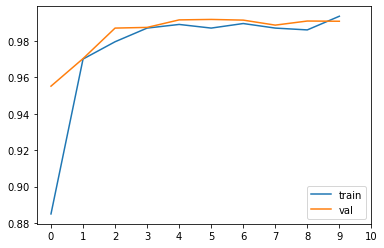

In [48]:
plt.plot(history_vgg16.history['binary_accuracy'], label='train')
plt.plot(history_vgg16.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(11))
plt.legend()

In [49]:
#Saving the best model using callbacks

In [50]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'mordified_X_{epoch:02d}_{val_binary_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_binary_accuracy')

In [74]:
#Retrain model_X and save the best model

In [73]:
history_X=model_X.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks =[checkpoint]
)

Epoch 1/10
1600/1600 [==============================] - 646s 403ms/step - loss: 0.0273 - binary_accuracy: 0.9887 - val_loss: 0.0179 - val_binary_accuracy: 0.9950


/home/zach/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
1600/1600 [==============================] - 655s 409ms/step - loss: 0.0167 - binary_accuracy: 0.9953 - val_loss: 0.0173 - val_binary_accuracy: 0.9954
Epoch 3/10
1600/1600 [==============================] - 696s 435ms/step - loss: 0.0145 - binary_accuracy: 0.9959 - val_loss: 0.0144 - val_binary_accuracy: 0.9964
Epoch 4/10
1600/1600 [==============================] - 783s 490ms/step - loss: 0.0135 - binary_accuracy: 0.9962 - val_loss: 0.0139 - val_binary_accuracy: 0.9965
Epoch 5/10
1600/1600 [==============================] - 744s 465ms/step - loss: 0.0128 - binary_accuracy: 0.9965 - val_loss: 0.0131 - val_binary_accuracy: 0.9967
Epoch 6/10
1600/1600 [==============================] - 740s 462ms/step - loss: 0.0123 - binary_accuracy: 0.9967 - val_loss: 0.0128 - val_binary_accuracy: 0.9969
Epoch 7/10
1600/1600 [==============================] - 614s 383ms/step - loss: 0.0119 - binary_accuracy: 0.9967 - val_loss: 0.0141 - val_binary_accuracy: 0.9967
Epoch 8/10
1600/1600 [======

#test final model

In [76]:
# load first test image 

In [82]:
path= "./img/test_1.jpg"

img_1 = load_img(path, target_size=(IMAGE_SHAPE, IMAGE_SHAPE))

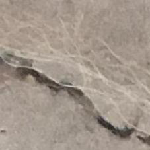

In [84]:
img_1

In [87]:
def prepare_img(x):
    return x / 255.0

In [102]:
def eval_img(pred):
    if pred >= 0.5:
        print('Crack detected')
    else:
        print('No cracks')

In [103]:
#preprocess image1

x = np.array(img_1, dtype='float32')
X = np.array([x])
X = prepare_img(X)

In [104]:
pred = model_X.predict(X)

model_X.predict(X)


array([[0.9630732]], dtype=float32)

In [105]:
eval_img(pred)

Crack detected


In [93]:
pred[0]

array([0.9630732], dtype=float32)

In [94]:
path= "./img/test_2.jpg"

img_2 = load_img(path, target_size=(IMAGE_SHAPE, IMAGE_SHAPE))

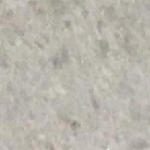

In [95]:
img_2

In [96]:
#preprocess image2

x = np.array(img_2, dtype='float32')
X = np.array([x])
X = prepare_img(X)

In [97]:
pred = model_X.predict(X)

model_X.predict(X)

array([[0.03461878]], dtype=float32)

In [101]:
eval_img(pred)

No cracks


Serving model using serverless approach

In [107]:
# Convert model_X keras to TF-lite

model = keras.models.load_model('mordified_X_10_0.997.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_X.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

2021-12-11 03:38:12.313294: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpu3pnlub9/assets


/home/zach/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2021-12-11 03:38:23.481533: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-12-11 03:38:23.481859: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-11 03:38:23.503991: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.013ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2021-12-11 03:38:25.482133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_form

In [108]:
!ls -lh model_X.tflite

-rwxrwxrwx 1 zach zach 80M Dec 11 03:38 model_X.tflite


In [110]:
interpreter = tflite.Interpreter(model_path='model_X.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [112]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)

In [114]:
eval_img(pred)

Crack detected


Remove Tensorflow dependency

In [117]:
!pip install keras-image-helper
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


Use tensorflowlite as tflite
*import model as tflite 

In [118]:
import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

In [120]:
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [134]:
preprocessor = create_preprocessor('xception', target_size=(IMAGE_SHAPE, IMAGE_SHAPE))

url = 'https://raw.githubusercontent.com/ZachJon1/capstone_project/main/img/test_1.jpg?token=AOGFKC6YCRCGNT5L6RFTCITBWR44G'

X = preprocessor.from_url(url)

In [135]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)

In [136]:
eval_img(pred)

Crack detected


In [137]:
preprocessor = create_preprocessor('xception', target_size=(IMAGE_SHAPE, IMAGE_SHAPE))

url = 'https://raw.githubusercontent.com/ZachJon1/capstone_project/main/img/test_2.jpg?token=AOGFKCZ6AAQQUWAOQ5FAJCTBWR47O'

X = preprocessor.from_url(url)

In [138]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)

In [139]:
eval_img(pred)

No cracks
